# GIK Character Prediction Model

Train a model to predict keyboard characters from IMU sensor data.

Best config: LSTM + Focal Loss (~37% test accuracy)

In [31]:
import os
os.environ['KMP_DUPLICATE_LIB_OK'] = 'TRUE'

import sys
import torch
import numpy as np
import matplotlib.pyplot as plt

# Add project root to path
PROJECT_ROOT = os.path.dirname(os.path.abspath('__file__'))
if PROJECT_ROOT not in sys.path:
    sys.path.insert(0, PROJECT_ROOT)

from pretraining import preprocess_and_export, preprocess_multiple_sources, load_preprocessed_dataset, export_dataset_to_csv
from src.pre_processing.alignment import INDEX_TO_CHAR, CHAR_TO_INDEX, NUM_CLASSES
from ml.models.basic_nn import create_model_from_dataset, GIKTrainer, decode_predictions

torch.manual_seed(42)
np.random.seed(42)

DEVICE = 'cuda' if torch.cuda.is_available() else 'mps' if torch.backends.mps.is_available() else 'cpu'
print(f"PyTorch {torch.__version__} | Device: {DEVICE}")

PyTorch 2.10.0 | Device: mps


## Configuration

In [32]:
# Data paths - Using data_hazel_2 with multiple sources
DATA_DIR = "data_hazel_2"

# Multiple data sources (paired keyboard + IMU files)
KEYBOARD_FILES = ["Keyboard_1.csv", "Keyboard_2.csv", "Keyboard_3.csv", "Keyboard_4.csv"]
LEFT_FILES = ["Left_1.csv", "Left_2.csv", "Left_3.csv", "Left_4.csv"]
RIGHT_FILES = None  # Set to list of files if available

PROCESSED_DATA_PATH = os.path.join(DATA_DIR, "processed_dataset.pt")

# Training config - OPTIMIZED (best: LSTM + Focal Loss ~37% test acc)
CONFIG = {
    'max_seq_length': 10,
    'hidden_dim': 128,
    'num_layers': 2,
    'dropout': 0.5,  # Increased for regularization
    'batch_size': 32,
    'learning_rate': 5e-4,
    'weight_decay': 1e-3,  # L2 regularization
    'epochs': 100,
    'early_stopping': 20,
    # Model: 'lstm' (best) | 'transformer' | 'attention_lstm' | 'gru' | 'rnn' | 'cnn'
    'model_type': 'lstm',
    'bidirectional': True,  # For LSTM/GRU
    'use_focal_loss': True,  # Handles class imbalance
    'focal_gamma': 2.0,
}

print(f"Data dir: {DATA_DIR}")
print(f"Keyboard files: {KEYBOARD_FILES}")
print(f"Left IMU files: {LEFT_FILES}")
print(f"Right IMU files: {RIGHT_FILES}")
print(f"Model: {CONFIG['model_type']}")
print(f"Seq length: {CONFIG['max_seq_length']}")

Data dir: data_hazel_2
Keyboard files: ['Keyboard_1.csv', 'Keyboard_2.csv', 'Keyboard_3.csv', 'Keyboard_4.csv']
Left IMU files: ['Left_1.csv', 'Left_2.csv', 'Left_3.csv', 'Left_4.csv']
Right IMU files: None
Model: lstm
Seq length: 10


## Preprocess Data

In [33]:
# Preprocess and combine multiple data sources
metadata = preprocess_multiple_sources(
    data_dir=DATA_DIR,
    keyboard_files=KEYBOARD_FILES,
    left_files=LEFT_FILES,
    right_files=RIGHT_FILES,
    output_path=PROCESSED_DATA_PATH,
    max_seq_length=CONFIG['max_seq_length'],
    normalize=True,
    apply_filtering=True
)
print(f"\nTotal Samples: {metadata['num_samples']} | Input dim: {metadata['input_dim']} | Sources: {metadata['num_sources']}")

Loading data from data_hazel_2...
  Keyboard files: ['Keyboard_1.csv', 'Keyboard_2.csv', 'Keyboard_3.csv', 'Keyboard_4.csv']
  Left IMU files: ['Left_1.csv', 'Left_2.csv', 'Left_3.csv', 'Left_4.csv']

Processing source 1/4: Keyboard_1.csv


/Users/souparna/perceptron-gik/src/imu/v1/mathlib.py:7: RuntimeWarning: invalid value encountered in divide
  return x / np.linalg.norm(x)
/Users/souparna/perceptron-gik/src/imu/v1/main.py:119: RuntimeWarning: divide by zero encountered in scalar divide
  Ra = [(acc_noise/np.linalg.norm(at))**2 + (1 - grm/np.linalg.norm(at))**2]*3


Skipped characters not in vocabulary: {'shift': 2, '*': 2}
  Added 2111 samples (total: 2111)

Processing source 2/4: Keyboard_2.csv


/Users/souparna/perceptron-gik/src/imu/v1/mathlib.py:7: RuntimeWarning: invalid value encountered in divide
  return x / np.linalg.norm(x)
/Users/souparna/perceptron-gik/src/imu/v1/main.py:119: RuntimeWarning: divide by zero encountered in scalar divide
  Ra = [(acc_noise/np.linalg.norm(at))**2 + (1 - grm/np.linalg.norm(at))**2]*3


Skipped characters not in vocabulary: {'shift': 60, '#': 1, '(': 10, '_': 2, ',': 4, ')': 6, ':': 7, 'delete': 1, "'": 3, 'ctrl': 4, '-': 5, '%': 1, '\\': 2, '<': 1, '*': 8, '>': 1, '+': 2, 'right': 1, '.': 5, '=': 1, '/': 1}
  Added 853 samples (total: 2964)

Processing source 3/4: Keyboard_3.csv


/Users/souparna/perceptron-gik/src/imu/v1/mathlib.py:7: RuntimeWarning: invalid value encountered in divide
  return x / np.linalg.norm(x)
/Users/souparna/perceptron-gik/src/imu/v1/main.py:119: RuntimeWarning: divide by zero encountered in scalar divide
  Ra = [(acc_noise/np.linalg.norm(at))**2 + (1 - grm/np.linalg.norm(at))**2]*3


Skipped characters not in vocabulary: {'#': 3, 'shift': 257, '.': 3, '$': 6, '(': 9, ')': 11, '=': 24, '_': 37, '\\': 46, '{': 58, '}': 50, '^': 12, '*': 1, ';': 4, ',': 8, '[': 6, ']': 5, 'right': 10, '&': 1, ':': 2, 'caps lock': 2, 'left': 1, 'delete': 2, '-': 1, 'ctrl': 18, 'alt': 1}
  Added 556 samples (total: 3520)

Processing source 4/4: Keyboard_4.csv


/Users/souparna/perceptron-gik/src/imu/v1/mathlib.py:7: RuntimeWarning: invalid value encountered in divide
  return x / np.linalg.norm(x)
/Users/souparna/perceptron-gik/src/imu/v1/main.py:119: RuntimeWarning: divide by zero encountered in scalar divide
  Ra = [(acc_noise/np.linalg.norm(at))**2 + (1 - grm/np.linalg.norm(at))**2]*3


Skipped characters not in vocabulary: {'.': 38, 'ctrl': 72, 'shift': 98, "'": 3, ',': 10, '?': 1, '<nan>': 2, 'f5': 10, 'right': 538, 'delete': 88, ']': 1, '"': 10, 'up': 41, 'left': 92, 'down': 41, 'right ctrl': 7, '/': 5, '-': 10, '#': 7, '\\': 3, '[': 1, 'caps lock': 15, '*': 12, '(': 3, ':': 4, '=': 1}
  Added 3346 samples (total: 6866)

Total skipped characters: {'shift': 417, '*': 23, '#': 11, '(': 22, '_': 39, ',': 22, ')': 17, ':': 13, 'delete': 91, "'": 6, 'ctrl': 94, '-': 16, '%': 1, '\\': 51, '<': 1, '>': 1, '+': 2, 'right': 549, '.': 46, '=': 26, '/': 6, '$': 6, '{': 58, '}': 50, '^': 12, ';': 4, '[': 7, ']': 6, '&': 1, 'caps lock': 17, 'left': 93, 'alt': 1, '?': 1, '<nan>': 2, 'f5': 10, '"': 10, 'up': 41, 'down': 41, 'right ctrl': 7}

Processing 6866 total samples...

Saved preprocessed dataset to data_hazel_2/processed_dataset.pt
Saved metadata to data_hazel_2/processed_dataset_metadata.json
  - Total samples: 6866
  - Input dim: 99
  - Sources combined: 4

Total Samples:

In [34]:
# Export to CSV for inspection (optional)
export_dataset_to_csv(PROCESSED_DATA_PATH, DATA_DIR, include_features=True)

Saved summary to data_hazel_2/dataset_summary.csv
Saved features to data_hazel_2/dataset_features.csv

Dataset Info:
  Total samples: 6866
  Exported samples: 6866
  Input dim: 99
  Max seq length: 10
  Num classes: 40

Class Distribution:
  SPACE: 1041
  e: 575
  BACKSPACE: 544
  t: 412
  o: 391
  a: 377
  n: 355
  i: 339
  s: 295
  r: 295
  l: 234
  h: 209
  m: 184
  u: 163
  d: 157


'data_hazel_2/dataset_summary.csv'

## Load Dataset & Create Model

In [35]:
dataset = load_preprocessed_dataset(PROCESSED_DATA_PATH)
print(f"Dataset: {len(dataset)} samples | Input dim: {dataset.input_dim}")

# Create model
model = create_model_from_dataset(
    dataset,
    model_type=CONFIG['model_type'],
    hidden_dim=CONFIG['hidden_dim'],
    num_layers=CONFIG['num_layers'],
    dropout=CONFIG['dropout'],
)

# Print model architecture
print("\n" + "=" * 60)
print("Model architecture")
print("=" * 60)
print(model)
print("=" * 60)
print(f"Parameters: {sum(p.numel() for p in model.parameters()):,}")
print(f"Parameters: {sum(p.numel() for p in model.parameters()):,}")

Dataset: 6866 samples | Input dim: 99

Model architecture
GIKModelWrapper(
  (input_projection): Sequential(
    (0): Linear(in_features=99, out_features=128, bias=True)
    (1): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
    (2): ReLU()
    (3): Dropout(p=0.3, inplace=False)
  )
  (inner_model): LSTMModel(
    (lstm): LSTM(128, 128, num_layers=2, batch_first=True, dropout=0.5, bidirectional=True)
    (projection): Linear(in_features=256, out_features=128, bias=True)
  )
  (classifier): Sequential(
    (0): Linear(in_features=128, out_features=64, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.3, inplace=False)
    (3): Linear(in_features=64, out_features=40, bias=True)
  )
)
Parameters: 716,264
Parameters: 716,264


## Train Model

In [36]:
trainer = GIKTrainer(
    model=model,
    dataset=dataset,
    batch_size=CONFIG['batch_size'],
    learning_rate=CONFIG['learning_rate'],
    device=DEVICE,
    use_focal_loss=CONFIG.get('use_focal_loss', False),
    focal_gamma=CONFIG.get('focal_gamma', 2.0)
)

history = trainer.train(
    epochs=CONFIG['epochs'],
    early_stopping_patience=CONFIG['early_stopping']
)

Training on mps
Train: 5492, Val: 686, Test: 688 (causal split, no shuffle)
------------------------------------------------------------
Epoch   1/100 | Train Loss: 2.9365 | Train Acc: 0.1371 | Val Loss: 2.7271 | Val Acc: 0.2026
  -> Saved best model (val_loss: 2.7271)
Epoch   2/100 | Train Loss: 2.5284 | Train Acc: 0.2021 | Val Loss: 2.5470 | Val Acc: 0.2099
  -> Saved best model (val_loss: 2.5470)
Epoch   3/100 | Train Loss: 2.3655 | Train Acc: 0.2360 | Val Loss: 2.4317 | Val Acc: 0.2362
  -> Saved best model (val_loss: 2.4317)
Epoch   4/100 | Train Loss: 2.2427 | Train Acc: 0.2678 | Val Loss: 2.3934 | Val Acc: 0.2536
  -> Saved best model (val_loss: 2.3934)
Epoch   5/100 | Train Loss: 2.1341 | Train Acc: 0.2864 | Val Loss: 2.3780 | Val Acc: 0.2434
  -> Saved best model (val_loss: 2.3780)
Epoch   6/100 | Train Loss: 2.0523 | Train Acc: 0.2992 | Val Loss: 2.2992 | Val Acc: 0.2668
  -> Saved best model (val_loss: 2.2992)
Epoch   7/100 | Train Loss: 1.9709 | Train Acc: 0.3196 | Val Loss

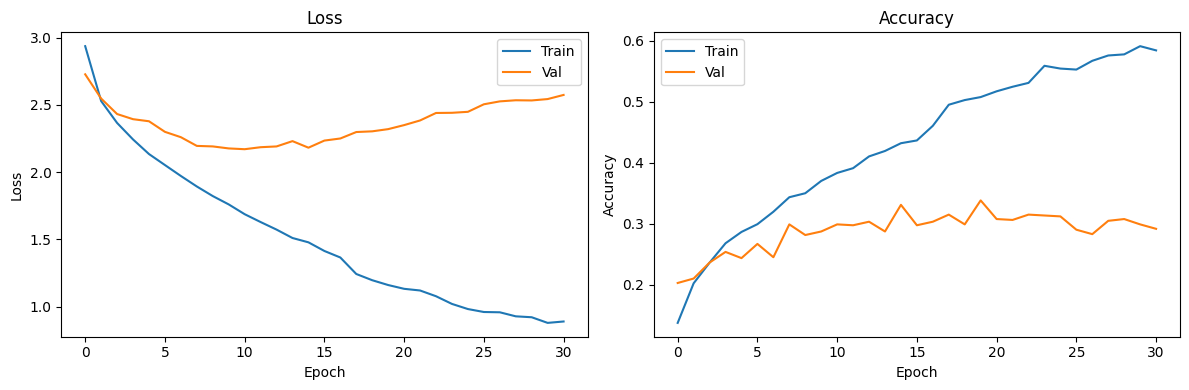

In [37]:
# Plot training history
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

axes[0].plot(history['train_loss'], label='Train')
axes[0].plot(history['val_loss'], label='Val')
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Loss')
axes[0].legend()
axes[0].set_title('Loss')

axes[1].plot(history['train_acc'], label='Train')
axes[1].plot(history['val_acc'], label='Val')
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Accuracy')
axes[1].legend()
axes[1].set_title('Accuracy')

plt.tight_layout()
plt.show()

## Evaluate Model

In [38]:
# Evaluate on validation set
val_loss, val_acc = trainer.validate()
print(f"Validation Loss: {val_loss:.4f} | Validation Accuracy: {val_acc:.2%}")
print()

# Evaluate on test set
test_loss, test_acc = trainer.evaluate_test()
print(f"Test Loss: {test_loss:.4f} | Test Accuracy: {test_acc:.2%}")

Validation Loss: 2.5737 | Validation Accuracy: 29.15%

Test Loss: 2.7080 | Test Accuracy: 31.54%


In [39]:
# Helper function to display predictions
def show_predictions(data_subset, subset_name, max_samples=50):
    """Show predictions for a dataset subset."""
    model.eval()
    correct = 0
    results = []
    
    with torch.no_grad():
        for idx in range(len(data_subset)):
            x, y_true = data_subset[idx]
            x = x.unsqueeze(0).to(DEVICE)
            y_pred = model(x)
            
            true_char = INDEX_TO_CHAR.get(y_true.argmax().item(), '?')
            pred_char = INDEX_TO_CHAR.get(y_pred.argmax().item(), '?')
            
            is_correct = true_char == pred_char
            if is_correct:
                correct += 1
            
            results.append((true_char, pred_char, is_correct))
    
    # Print header
    print(f"=== {subset_name} Predictions ({correct}/{len(results)} correct = {correct/len(results):.2%}) ===")
    print()
    
    # Show samples (up to max_samples)
    n_show = min(max_samples, len(results))
    for i, (true_char, pred_char, is_correct) in enumerate(results[:n_show]):
        # Display special chars nicely
        true_disp = {'\n': 'ENTER', ' ': 'SPACE', '\t': 'TAB', '\b': 'BKSP'}.get(true_char, true_char)
        pred_disp = {'\n': 'ENTER', ' ': 'SPACE', '\t': 'TAB', '\b': 'BKSP'}.get(pred_char, pred_char)
        match = '✓' if is_correct else '✗'
        print(f"{match} True: {true_disp:8} | Pred: {pred_disp:8}")
    
    if len(results) > n_show:
        print(f"... and {len(results) - n_show} more samples")
    print()

In [40]:
# Show validation predictions
show_predictions(trainer.val_dataset, 'Validation')

=== Validation Predictions (208/686 correct = 30.32%) ===

✗ True: g        | Pred: t       
✗ True: m        | Pred: a       
✗ True: a        | Pred: e       
✓ True: SPACE    | Pred: SPACE   
✗ True: d        | Pred: m       
✗ True: r        | Pred: SPACE   
✗ True: i        | Pred: SPACE   
✗ True: v        | Pred: t       
✗ True: e        | Pred: 1       
✗ True: e        | Pred: r       
✗ True: SPACE    | Pred: ENTER   
✗ True: BKSP     | Pred: c       
✓ True: BKSP     | Pred: BKSP    
✗ True: r        | Pred: BKSP    
✗ True: SPACE    | Pred: o       
✗ True: i        | Pred: s       
✗ True: n        | Pred: s       
✓ True: BKSP     | Pred: BKSP    
✗ True: m        | Pred: BKSP    
✗ True: p        | Pred: u       
✓ True: e        | Pred: e       
✗ True: r        | Pred: s       
✗ True: f        | Pred: e       
✓ True: e        | Pred: e       
✓ True: c        | Pred: c       
✗ True: i        | Pred: t       
✓ True: o        | Pred: o       
✓ True: n        | Pred

In [41]:
# Show test predictions
show_predictions(trainer.test_dataset, 'Test')

=== Test Predictions (220/688 correct = 31.98%) ===

✓ True: r        | Pred: r       
✓ True: a        | Pred: a       
✓ True: t        | Pred: t       
✗ True: i        | Pred: SPACE   
✗ True: o        | Pred: m       
✓ True: n        | Pred: n       
✗ True: ENTER    | Pred: m       
✗ True: n        | Pred: 0       
✓ True: a        | Pred: a       
✓ True: n        | Pred: n       
✓ True: o        | Pred: o       
✗ True: SPACE    | Pred: l       
✓ True: v        | Pred: v       
✓ True: 1        | Pred: 1       
✗ True: r        | Pred: c       
✓ True: o        | Pred: o       
✗ True: TAB      | Pred: a       
✓ True: ENTER    | Pred: ENTER   
✗ True: 5        | Pred: BKSP    
✓ True: BKSP     | Pred: BKSP    
✗ True: 2        | Pred: v       
✗ True: a        | Pred: c       
✗ True: r        | Pred: m       
✗ True: e        | Pred: o       
✓ True: SPACE    | Pred: SPACE   
✓ True: t        | Pred: t       
✗ True: h        | Pred: i       
✓ True: e        | Pred: e   

## Confusion Matrix

In [42]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

def plot_confusion_matrix(data_subset, subset_name):
    """Generate and plot confusion matrix for a dataset subset."""
    model.eval()
    y_true_list = []
    y_pred_list = []
    
    with torch.no_grad():
        for idx in range(len(data_subset)):
            x, y_true = data_subset[idx]
            x = x.unsqueeze(0).to(DEVICE)
            y_pred = model(x)
            
            y_true_list.append(y_true.argmax().item())
            y_pred_list.append(y_pred.argmax().item())
    
    # Get class labels
    classes = [INDEX_TO_CHAR.get(i, '?') for i in range(40)]
    # Make special characters readable
    display_classes = []
    for c in classes:
        if c == ' ':
            display_classes.append('SP')
        elif c == '\n':
            display_classes.append('ENT')
        elif c == '\b':
            display_classes.append('BS')
        elif c == '\t':
            display_classes.append('TAB')
        else:
            display_classes.append(c)
    
    # Compute confusion matrix
    cm = confusion_matrix(y_true_list, y_pred_list, labels=list(range(40)))
    
    # Plot
    fig, ax = plt.subplots(figsize=(16, 14))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                xticklabels=display_classes, yticklabels=display_classes,
                ax=ax, annot_kws={'size': 7})
    ax.set_xlabel('Predicted', fontsize=12)
    ax.set_ylabel('True', fontsize=12)
    ax.set_title(f'{subset_name} Confusion Matrix ({40} classes)', fontsize=14)
    plt.xticks(rotation=45, ha='right', fontsize=8)
    plt.yticks(rotation=0, fontsize=8)
    plt.tight_layout()
    plt.show()
    
    return cm

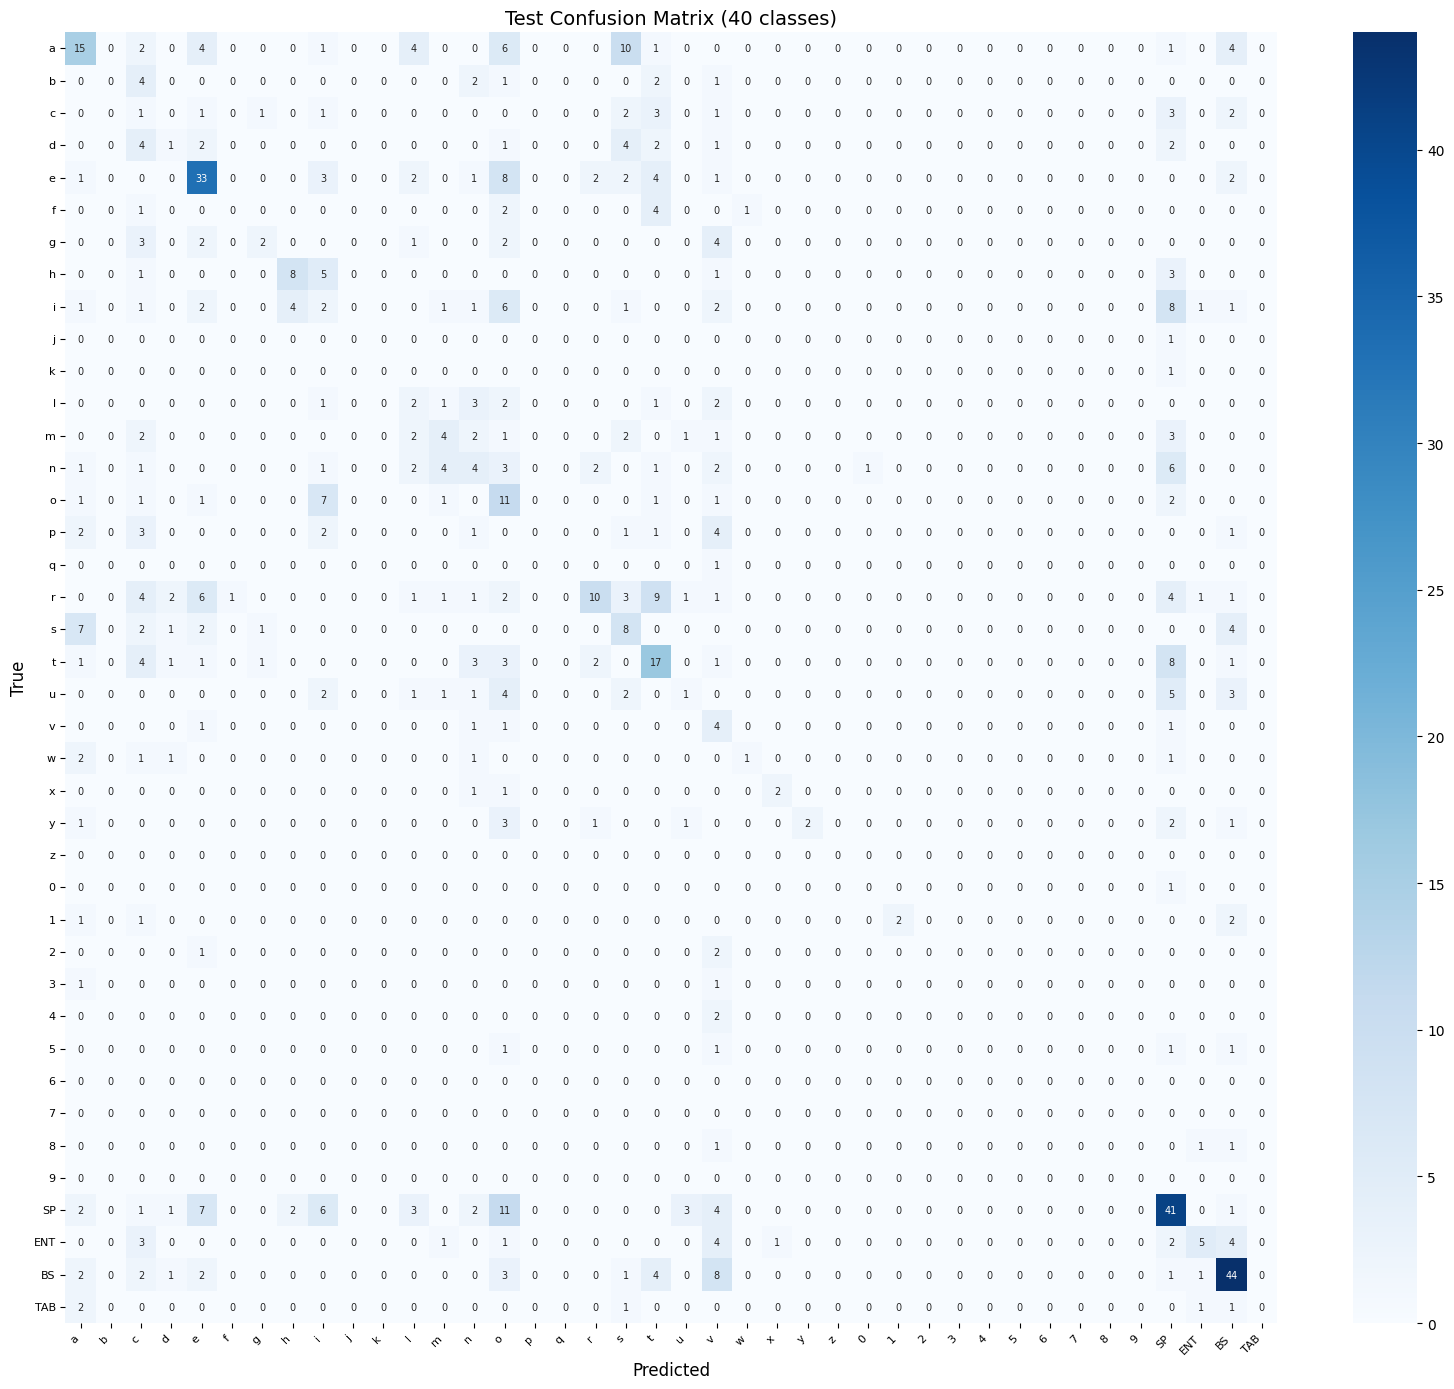

In [43]:
# Plot confusion matrix for test set
test_cm = plot_confusion_matrix(trainer.test_dataset, 'Test')

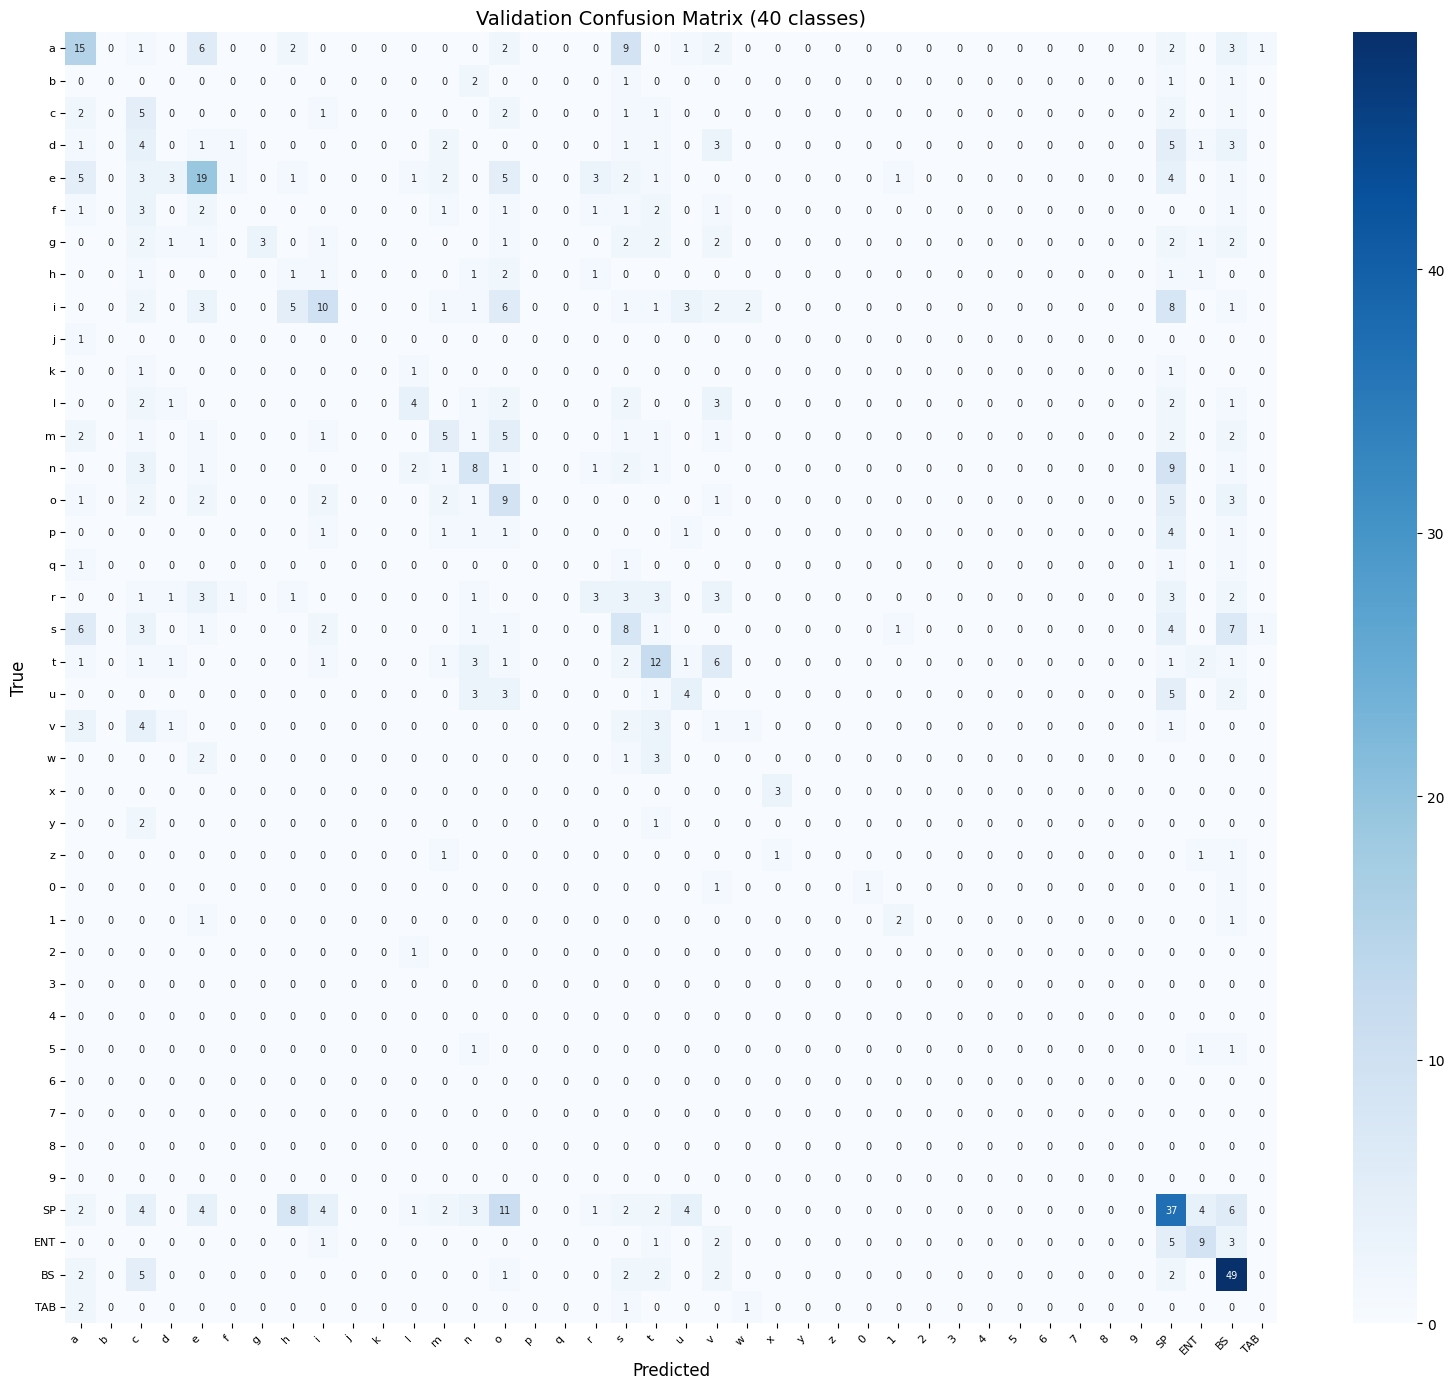

In [44]:
# Plot confusion matrix for validation set
val_cm = plot_confusion_matrix(trainer.val_dataset, 'Validation')

## Save Model

In [45]:
# MODEL_PATH = os.path.join(DATA_DIR, "gik_model.pt")
# torch.save({
#     'model_state_dict': model.state_dict(),
#     'config': CONFIG,
#     'input_dim': dataset.input_dim,
#     'metadata': metadata
# }, MODEL_PATH)
# print(f"Model saved to {MODEL_PATH}")